In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Principle Component Analysis with Aggregate Profiles

We can do principle component analysis to reduce the dimensionality across the repair outcomes to help identify the repair outcomes which result in the best seperation of the repair outcome profiles

In [2]:
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from src.data.load_dataset import load_lumc_outcomes
from src.config import get_common_barcodes

In [3]:
# takes about 6 minutes to load the data into memory
df = load_lumc_outcomes()
df.head()

/Users/colm/repos/MUSICian/src/data/load_dataset.py:80: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  totals = df_idx[["fraction_per_barcode"]].sum(level=["Target", "Alias", "Gene", "Barcode"])


Normalised per Gene


fraction_per_barcode  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.056075   
                           0610009B22Rik-1              0.001780   
                           0610009B22Rik-1              0.013351   
                           0610009B22Rik-1              0.002225   
                           0610009B22Rik-1              0.024477   

                                                lumc_category  del_len  \
Target Alias Gene          Barcode                                       
T1     MB01  0610009B22Rik 0610009B22Rik-1  1bp insertion - A        0   
                           0610009B22Rik-1  1bp insertion - C        0   
                           0610009B22Rik-1  1bp insertion - G        0   
                           0610009B22Rik-1  1bp insertion - T        0   
                           0610009B22Rik-1     >1bp insertion        0   

                                            countEvents  
Target Alias Gene          Barcode                       
T1     MB01  0610009B22Rik 0610009B22Rik-1          126  
                           0610009B22Rik-1            4  
                           0610009B22Rik-1           30  
                           0610009B22Rik-1            5  
                           0610009B22Rik-1           55

In [791]:
test = pd.read_csv(get_common_barcodes(), sep="\t")
test["Filtered"].unique()

array([0, 1, 2, 5, 3])

In [792]:
filtered_barcodes = pd.read_csv(get_common_barcodes(), sep="\t")
filtered_barcodes.head()

,Target,Alias,Gene,Barcode,Filtered,Counts,Corr_Within,Corr_Between,log10Count
0,T1,MB01,0610009B22Rik,0610009B22Rik-1,0,2247.0,0.952007,0.910326,3.351603
1,T1,MB01,0610009B22Rik,0610009B22Rik-2,0,2792.0,0.962390,0.939419,3.445915
2,T1,MB01,0610009B22Rik,0610009B22Rik-3,0,3907.0,0.966884,0.952470,3.591843
3,T1,MB01,0610009B22Rik,0610009B22Rik-4,0,3757.0,0.968739,0.955281,3.574841
4,T1,MB01,0610009B22Rik,0610009B22Rik-5,0,2549.0,0.965979,0.959352,3.406370


In [793]:
filtered_barcodes[filtered_barcodes["Filtered"] == 0].groupby(["Target", "Gene"]).sum()[["Counts"]]

Counts
Target Gene                  
T1     0610009B22Rik  31948.0
       0610010K14Rik  42869.0
       0610030E20Rik  16913.0
       0610040J01Rik  12071.0
       1110004F10Rik  12516.0
...                       ...
T3     Zzef1          28293.0
       Zzz3           31300.0
       a              24319.0
       ccdc198        27461.0
       mei-04         19294.0

[53298 rows x 1 columns]

In [950]:
kept_indexes = pd.MultiIndex.from_frame(filtered_barcodes[filtered_barcodes["Filtered"].isin([0,5])][["Target", "Alias", "Gene", "Barcode"]])
kept_indexes.to_list()[:5]

[('T1', 'MB01', '0610009B22Rik', '0610009B22Rik-1'),
 ('T1', 'MB01', '0610009B22Rik', '0610009B22Rik-2'),
 ('T1', 'MB01', '0610009B22Rik', '0610009B22Rik-3'),
 ('T1', 'MB01', '0610009B22Rik', '0610009B22Rik-4'),
 ('T1', 'MB01', '0610009B22Rik', '0610009B22Rik-5')]

### Do our categories capture the variation in repair outcomes between target sites?

Run PCA analysis on Target Site/Replicate/gRNA x Outcomes 

In [1257]:
target_site_to_test = "T1"

In [1258]:
df.head()

fraction_per_barcode  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.056075   
                           0610009B22Rik-1              0.001780   
                           0610009B22Rik-1              0.013351   
                           0610009B22Rik-1              0.002225   
                           0610009B22Rik-1              0.024477   

                                                lumc_category  del_len  \
Target Alias Gene          Barcode                                       
T1     MB01  0610009B22Rik 0610009B22Rik-1  1bp insertion - A        0   
                           0610009B22Rik-1  1bp insertion - C        0   
                           0610009B22Rik-1  1bp insertion - G        0   
                           0610009B22Rik-1  1bp insertion - T        0   
                           0610009B22Rik-1     >1bp insertion        0   

                                            countEvents  
Target Alias Gene          Barcode                       
T1     MB01  0610009B22Rik 0610009B22Rik-1          126  
                           0610009B22Rik-1            4  
                           0610009B22Rik-1           30  
                           0610009B22Rik-1            5  
                           0610009B22Rik-1           55

In [1259]:
df.groupby(["Alias", "Barcode"]).sum().head()

fraction_per_barcode  del_len  countEvents
Alias Barcode                                                    
MB01  0610009B22Rik-1                   1.0      529         2247
      0610009B22Rik-2                   1.0      719         2792
      0610009B22Rik-3                   1.0      779         3907
      0610009B22Rik-4                   1.0      609         3757
      0610009B22Rik-5                   1.0      529         2549

In [1260]:
X = df.reset_index()
X.head()

,Target,Alias,Gene,Barcode,fraction_per_barcode,lumc_category,del_len,countEvents
0,T1,MB01,0610009B22Rik,0610009B22Rik-1,0.056075,1bp insertion - A,0,126
1,T1,MB01,0610009B22Rik,0610009B22Rik-1,0.001780,1bp insertion - C,0,4
2,T1,MB01,0610009B22Rik,0610009B22Rik-1,0.013351,1bp insertion - G,0,30
3,T1,MB01,0610009B22Rik,0610009B22Rik-1,0.002225,1bp insertion - T,0,5
4,T1,MB01,0610009B22Rik,0610009B22Rik-1,0.024477,>1bp insertion,0,55


In [1261]:
X["Feature"] = X["lumc_category"] + ", " + X["del_len"].astype(str)

In [1262]:
X.groupby(["Alias", "Barcode"]).size().groupby(["Alias"]).size()

Alias
MB01    89414
MB02    89423
MB03    89492
MB04    89481
MB05    89477
MB06    89478
dtype: int64

In [1263]:
X = X.pivot(index=["Target", "Alias", "Gene", "Barcode"], columns=["Feature"], values="fraction_per_barcode").fillna(0)
X.head()

Feature                                     1bp insertion - A, 0  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.056075   
                           0610009B22Rik-2              0.061605   
                           0610009B22Rik-3              0.048887   
                           0610009B22Rik-4              0.074528   
                           0610009B22Rik-5              0.090231   

Feature                                     1bp insertion - C, 0  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.001780   
                           0610009B22Rik-2              0.002507   
                           0610009B22Rik-3              0.000768   
                           0610009B22Rik-4              0.005323   
                           0610009B22Rik-5              0.006277   

Feature                                     1bp insertion - G, 0  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.013351   
                           0610009B22Rik-2              0.002865   
                           0610009B22Rik-3              0.009726   
                           0610009B22Rik-4              0.007453   
                           0610009B22Rik-5              0.002354   

Feature                                     1bp insertion - T, 0  \
Target Alias Gene          Barcode                                 
T1     MB01  0610009B22Rik 0610009B22Rik-1              0.002225   
                           0610009B22Rik-2              0.002507   
                           0610009B22Rik-3              0.010238   
                           0610009B22Rik-4              0.010647   
                           0610009B22Rik-5              0.000000   

Feature                                     >1bp insertion, 0  \
Target Alias Gene          Barcode                              
T1     MB01  0610009B22Rik 0610009B22Rik-1           0.024477   
                           0610009B22Rik-2           0.032235   
                           0610009B22Rik-3           0.016381   
                           0610009B22Rik-4           0.033537   
                           0610009B22Rik-5           0.014123   

Feature                                     Deletion 0bp microhomology, 1  \
Target Alias Gene          Barcode                                          
T1     MB01  0610009B22Rik 0610009B22Rik-1                       0.000890   
                           0610009B22Rik-2                       0.001433   
                           0610009B22Rik-3                       0.000000   
                           0610009B22Rik-4                       0.000000   
                           0610009B22Rik-5                       0.000000   

Feature                                     Deletion 0bp microhomology, 10  \
Target Alias Gene          Barcode                                           
T1     MB01  0610009B22Rik 0610009B22Rik-1                        0.010236   
                           0610009B22Rik-2                        0.005014   
                           0610009B22Rik-3                        0.000000   
                           0610009B22Rik-4                        0.000000   
                           0610009B22Rik-5                        0.000785   

Feature                                     Deletion 0bp microhomology, 11  \
Target Alias Gene          Barcode                                           
T1     MB01  0610009B22Rik 0610009B22Rik-1                        0.005785   
                           0610009B22Rik-2                        0.003223   
                           0610009B22Rik-3                        0.005375   
                           0610009B22Rik-4                        0.006654   
                           0610009B22Rik-5                        0.003531   

Fe

In [1264]:
X = X.div(X.sum(axis=1), axis=0)

In [1265]:
X = X.loc[kept_indexes]
X.shape

(431805, 105)

In [1266]:
X = X.groupby(["Target", "Gene"]).mean()

In [1267]:
X.head()

Feature               1bp insertion - A, 0  1bp insertion - C, 0  \
Target Gene                                                        
T1     0610009B22Rik              0.066606              0.002645   
       0610010K14Rik              0.061616              0.001262   
       0610030E20Rik              0.061400              0.001579   
       0610040J01Rik              0.059829              0.000870   
       1110004F10Rik              0.057918              0.001241   

Feature               1bp insertion - G, 0  1bp insertion - T, 0  \
Target Gene                                                        
T1     0610009B22Rik              0.007200              0.003330   
       0610010K14Rik              0.005674              0.003084   
       0610030E20Rik              0.007635              0.003827   
       0610040J01Rik              0.011332              0.001947   
       1110004F10Rik              0.006264              0.003434   

Feature               >1bp insertion, 0  Deletion 0bp microhomology, 1  \
Target Gene                                                              
T1     0610009B22Rik           0.023095                       0.000000   
       0610010K14Rik           0.028841                       0.000266   
       0610030E20Rik           0.024259                       0.000366   
       0610040J01Rik           0.028188                       0.001234   
       1110004F10Rik           0.019169                       0.000000   

Feature               Deletion 0bp microhomology, 10  \
Target Gene                                            
T1     0610009B22Rik                        0.002578   
       0610010K14Rik                        0.002203   
       0610030E20Rik                        0.002331   
       0610040J01Rik                        0.001772   
       1110004F10Rik                        0.002718   

Feature               Deletion 0bp microhomology, 11  \
Target Gene                                            
T1     0610009B22Rik                        0.007095   
       0610010K14Rik                        0.003486   
       0610030E20Rik                        0.007094   
       0610040J01Rik                        0.004714   
       1110004F10Rik                        0.002201   

Feature               Deletion 0bp microhomology, 12  \
Target Gene                                            
T1     0610009B22Rik                        0.001180   
       0610010K14Rik                        0.001202   
       0610030E20Rik                        0.000000   
       0610040J01Rik                        0.000741   
       1110004F10Rik                        0.001578   

Feature               Deletion 0bp microhomology, 13  ...  \
Target Gene                                           ...   
T1     0610009B22Rik                        0.001077  ...   
       0610010K14Rik                        0.001116  ...   
       0610030E20Rik                        0.001097  ...   
       0610040J01Rik                        0.001032  ...   
       1110004F10Rik                        0.002880  ...   

Feature               Deletion 4bp microhomology, 11  \
Target Gene                                            
T1     0610009B22Rik                        0.121496   
       0610010K14Rik                        0.126866   
       0610030E20Rik                        0.140248   
       0610040J01Rik                        0.137680   
       1110004F10Rik                        0.137532   

Feature               Deletion 4bp microhomology, 30  \
Target Gene                                            
T1     0610009B22Rik                             0.0   
       0610010K14Rik                             0.0   
       0610030E20Rik                             0.0   
       0610040J01Rik                             0.0   
       1110004F10Rik                             0.0   

Feature               Deletion 5-15bp microhomology, 21  \
Target Gene                                               
T1     0610009B2

In [1268]:
X["Tandem Duplication, 0"] = X["Tandem Duplication, 0"] + X["Tandem Duplication plus, 0"]
X = X.drop("Tandem Duplication plus, 0", axis=1)

In [1269]:
X.sum(axis=1)

Target  Gene         
T1      0610009B22Rik    1.0
        0610010K14Rik    1.0
        0610030E20Rik    1.0
        0610040J01Rik    1.0
        1110004F10Rik    1.0
                        ... 
T3      Zzef1            1.0
        Zzz3             1.0
        a                1.0
        ccdc198          1.0
        mei-04           1.0
Length: 53436, dtype: float64

In [1270]:
sparseness = (X == 0).sum().sum() / (X.shape[0] * X.shape[1])
print("The matrix is {:.3f} sparse. Could this be a problem for PCA?".format(sparseness))

The matrix is 0.307 sparse. Could this be a problem for PCA?


In [1271]:
X.head()

Feature               1bp insertion - A, 0  1bp insertion - C, 0  \
Target Gene                                                        
T1     0610009B22Rik              0.066606              0.002645   
       0610010K14Rik              0.061616              0.001262   
       0610030E20Rik              0.061400              0.001579   
       0610040J01Rik              0.059829              0.000870   
       1110004F10Rik              0.057918              0.001241   

Feature               1bp insertion - G, 0  1bp insertion - T, 0  \
Target Gene                                                        
T1     0610009B22Rik              0.007200              0.003330   
       0610010K14Rik              0.005674              0.003084   
       0610030E20Rik              0.007635              0.003827   
       0610040J01Rik              0.011332              0.001947   
       1110004F10Rik              0.006264              0.003434   

Feature               >1bp insertion, 0  Deletion 0bp microhomology, 1  \
Target Gene                                                              
T1     0610009B22Rik           0.023095                       0.000000   
       0610010K14Rik           0.028841                       0.000266   
       0610030E20Rik           0.024259                       0.000366   
       0610040J01Rik           0.028188                       0.001234   
       1110004F10Rik           0.019169                       0.000000   

Feature               Deletion 0bp microhomology, 10  \
Target Gene                                            
T1     0610009B22Rik                        0.002578   
       0610010K14Rik                        0.002203   
       0610030E20Rik                        0.002331   
       0610040J01Rik                        0.001772   
       1110004F10Rik                        0.002718   

Feature               Deletion 0bp microhomology, 11  \
Target Gene                                            
T1     0610009B22Rik                        0.007095   
       0610010K14Rik                        0.003486   
       0610030E20Rik                        0.007094   
       0610040J01Rik                        0.004714   
       1110004F10Rik                        0.002201   

Feature               Deletion 0bp microhomology, 12  \
Target Gene                                            
T1     0610009B22Rik                        0.001180   
       0610010K14Rik                        0.001202   
       0610030E20Rik                        0.000000   
       0610040J01Rik                        0.000741   
       1110004F10Rik                        0.001578   

Feature               Deletion 0bp microhomology, 13  ...  \
Target Gene                                           ...   
T1     0610009B22Rik                        0.001077  ...   
       0610010K14Rik                        0.001116  ...   
       0610030E20Rik                        0.001097  ...   
       0610040J01Rik                        0.001032  ...   
       1110004F10Rik                        0.002880  ...   

Feature               Deletion 3bp microhomology, 9  \
Target Gene                                           
T1     0610009B22Rik                       0.000269   
       0610010K14Rik                       0.000217   
       0610030E20Rik                       0.000000   
       0610040J01Rik                       0.000321   
       1110004F10Rik                       0.000364   

Feature               Deletion 4bp microhomology, 11  \
Target Gene                                            
T1     0610009B22Rik                        0.121496   
       0610010K14Rik                        0.126866   
       0610030E20Rik                        0.140248   
       0610040J01Rik                        0.137680   
       1110004F10Rik                        0.137532   

Feature               Deletion 4bp microhomology, 30  \
Target Gene                                            
T1     0610009B22Rik         

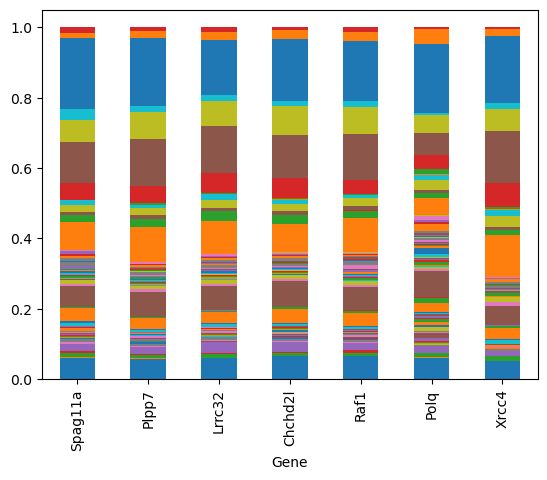

In [1272]:
examples = X.xs("T1", level="Target").index.to_series().sample(5)
ax = pd.concat((X.xs("T1", level="Target").loc[examples],
    X.xs("T1", level="Target").loc[[("Polq"), ("Xrcc4")],]), axis=0).fillna(0).plot(kind='bar', stacked=True)
ax.get_legend().remove()


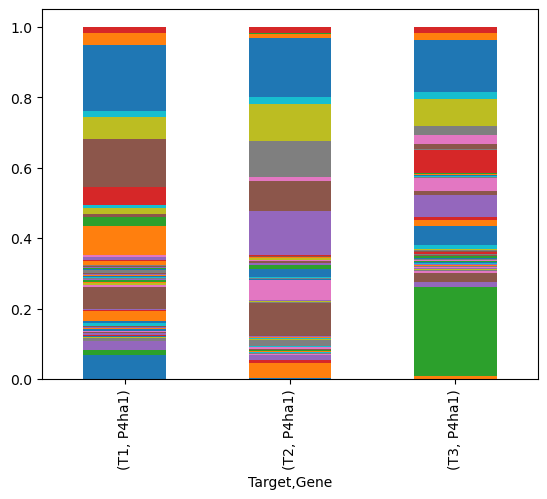

In [1273]:
idx = pd.IndexSlice
ax = X.loc[idx[:,'P4ha1'],].fillna(0).plot(kind='bar', stacked=True)
ax.get_legend().remove()

In [1274]:
X = X.xs(target_site_to_test, level="Target")

In [1275]:
X = X.loc[:, (X != 0).any(axis=0)]
X.shape

(17547, 87)

In [1276]:
# X.hist(sharex=False, sharey=False, figsize=(15,15))
# samples_to_pairplot = X.iloc[:,:10].sample(10000)
# samples_to_pairplot["Alias"] = X.loc[samples_to_pairplot.index].index.get_level_values("Alias").to_list()
# sns.pairplot(samples_to_pairplot, hue="Alias", palette="Paired", hue_order=["MB0" + str(i) for i in range(1,7)])


In [1277]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# standardise the data
scaler = StandardScaler()
X_st = scaler.fit_transform(X)
X_st = pd.DataFrame(X_st, index=X.index, columns=X.columns)
X_st.head()

Feature,"1bp insertion - A, 0","1bp insertion - C, 0","1bp insertion - G, 0","1bp insertion - T, 0",">1bp insertion, 0","Deletion 0bp microhomology, 1","Deletion 0bp microhomology, 10","Deletion 0bp microhomology, 11","Deletion 0bp microhomology, 12","Deletion 0bp microhomology, 13",...,"Deletion 3bp microhomology, 30","Deletion 3bp microhomology, 6","Deletion 3bp microhomology, 9","Deletion 4bp microhomology, 11","Deletion with insertion, 0","Deletion with templated insertion, 0","Homology Directed Repair, 0","Large Deletion, 0","Tandem Duplication, 0","Very Large Deletion, 0"
Gene,,,,,,,,,,,,,,,,,,,,,
0610009B22Rik,0.509948,0.403107,-0.400644,-0.311871,-0.656507,-0.633341,0.452882,0.835645,0.356535,0.050226,...,-0.105930,0.996998,-0.267229,-0.304116,-0.574226,0.341661,0.081679,-0.369464,0.113683,0.523213
0610010K14Rik,-0.154893,-0.532385,-0.954060,-0.439009,0.528216,-0.239030,0.197784,-0.714017,0.379294,0.086254,...,-0.618582,0.615270,-0.337446,0.214784,0.071913,0.954512,-0.560317,0.192934,0.075097,-1.222302
0610030E20Rik,-0.183661,-0.318364,-0.243059,-0.054678,-0.416550,-0.089571,0.284994,0.835075,-0.867580,0.069485,...,-0.060848,-0.223960,-0.632064,1.507833,-0.902259,-0.075671,-0.736880,-2.372326,-0.595510,1.167731
0610040J01Rik,-0.392865,-0.797593,1.097666,-1.027620,0.393607,1.199734,-0.095826,-0.186727,-0.099328,0.009029,...,0.093274,0.925808,-0.196391,1.259677,0.801903,2.096387,-2.179671,0.562309,0.506357,-0.453659
1110004F10Rik,-0.647587,-0.546742,-0.740394,-0.257973,-1.465893,-0.633341,0.548011,-1.266071,0.769066,1.716921,...,-1.105250,1.133603,-0.138011,1.245424,-1.314903,-0.844710,1.351782,-0.095138,0.084182,-0.449517


In [1278]:
X_st.shape

(17547, 87)

In [1279]:
# fit the PCA model
pca_out = PCA().fit(X_st)

# get the component variance
print("Component variance")
print(pca_out.explained_variance_ratio_)

# Cumulative proportion of variance 
print("Cumulative proportion of variance explained")
cum_variance = np.cumsum(pca_out.explained_variance_ratio_)
print(np.cumsum(pca_out.explained_variance_ratio_))

Component variance
[1.78191485e-02 1.49630750e-02 1.35729411e-02 1.35122237e-02
 1.34103070e-02 1.32617591e-02 1.32500162e-02 1.31545788e-02
 1.30899161e-02 1.29534986e-02 1.29055375e-02 1.28943771e-02
 1.28376932e-02 1.27516893e-02 1.26896835e-02 1.26561198e-02
 1.25979773e-02 1.25315942e-02 1.24957913e-02 1.24443787e-02
 1.24240812e-02 1.23757055e-02 1.23471674e-02 1.23279843e-02
 1.22407042e-02 1.22103020e-02 1.21305777e-02 1.21191608e-02
 1.20882364e-02 1.20260899e-02 1.19625414e-02 1.18969845e-02
 1.18797808e-02 1.18404051e-02 1.18305510e-02 1.17848428e-02
 1.17374281e-02 1.17229178e-02 1.16844540e-02 1.16334724e-02
 1.16011677e-02 1.15752174e-02 1.15450615e-02 1.15111229e-02
 1.14745799e-02 1.14664703e-02 1.14483763e-02 1.13796222e-02
 1.13394653e-02 1.12877825e-02 1.12338211e-02 1.12022379e-02
 1.11644677e-02 1.11056741e-02 1.10832893e-02 1.10631228e-02
 1.09869551e-02 1.09723340e-02 1.09374754e-02 1.09255904e-02
 1.09031875e-02 1.08505241e-02 1.08100027e-02 1.07154429e-02
 1.06

0.04635516465913662

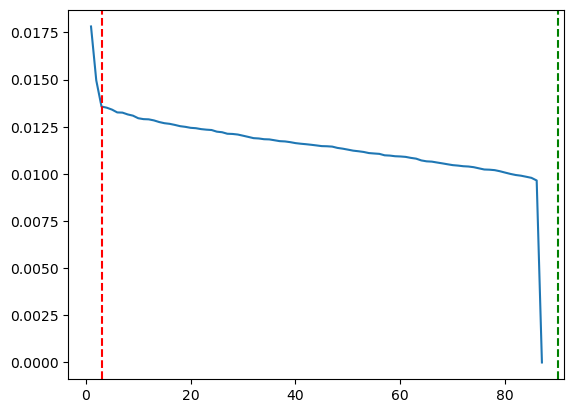

In [1280]:
# scree plot

MANUALLY_SELECTED_THRESHOLD = 3
sns.lineplot(y=pca_out.explained_variance_ratio_, x=np.arange(pca_out.n_components_) + 1)
plt.axvline(MANUALLY_SELECTED_THRESHOLD, ls="--", color="red")
plt.axvline(90, ls="--", color="green")
np.sum(pca_out.explained_variance_ratio_[:MANUALLY_SELECTED_THRESHOLD])

In [1281]:
kaisers_rule = sum(pca_out.explained_variance_ > 1)
kaisers_rule

44

57


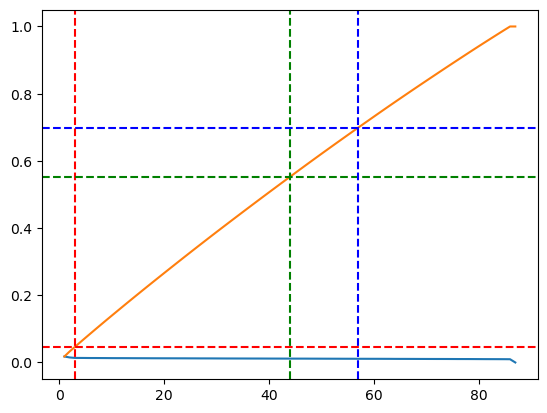

In [1282]:
VARIANCE_TO_EXPLAIN = .7

var_cumsum = np.cumsum(pca_out.explained_variance_ratio_)
variance_explained_by_num_pcs = sum(var_cumsum < VARIANCE_TO_EXPLAIN)
print(variance_explained_by_num_pcs)

sns.lineplot(y=pca_out.explained_variance_ratio_, x=np.arange(pca_out.n_components_) + 1)
sns.lineplot(y=var_cumsum, x=np.arange(pca_out.n_components_) + 1)

plt.axvline(MANUALLY_SELECTED_THRESHOLD, ls="--", color="red")
plt.axhline(var_cumsum[MANUALLY_SELECTED_THRESHOLD-1], ls="--", color="red")

plt.axvline(kaisers_rule, ls="--", color="green")
plt.axhline(var_cumsum[kaisers_rule-1], ls="--", color="green")

plt.axvline(variance_explained_by_num_pcs, ls="--", color="blue")
plt.axhline(var_cumsum[variance_explained_by_num_pcs-1], ls="--", color="blue")

In [1283]:
principle_components = pca_out.transform(X_st)
components_names = ["PC" + str(i+1) for i in range(principle_components.shape[1])]
pca_df = pd.DataFrame(principle_components, columns=components_names)
pca_df.shape

(17547, 87)

In [1284]:
principle_components[:,0].shape

(17547,)

In [1285]:
X.index.get_level_values("Gene")

Index(['0610009B22Rik', '0610010K14Rik', '0610030E20Rik', '0610040J01Rik',
       '1110004F10Rik', '1110017D15Rik', '1110032A03Rik', '1110032F04Rik',
       '1110059G10Rik', '1110065P20Rik',
       ...
       'Zxdb', 'Zxdc', 'Zyg11a', 'Zyg11b', 'Zyx', 'Zzef1', 'Zzz3', 'a',
       'ccdc198', 'mei-04'],
      dtype='object', name='Gene', length=17547)

Text(37.597222222222214, 0.5, 'PC2 - 0.015')

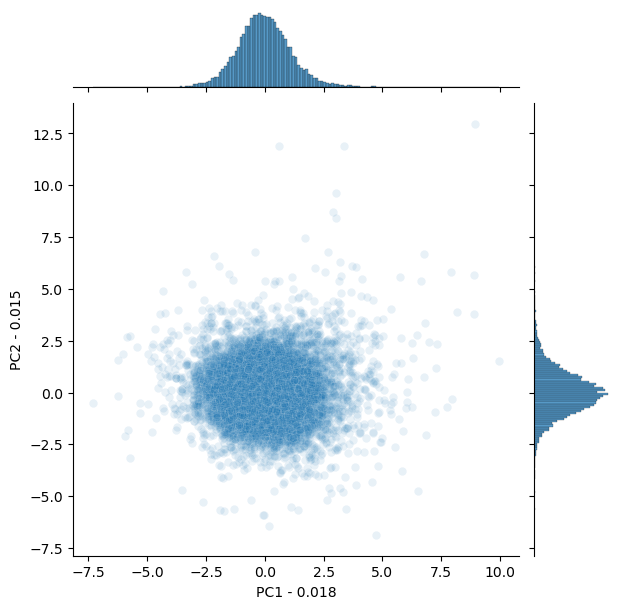

In [1286]:
h = sns.jointplot(x = principle_components[:,0], y = principle_components[:,1], alpha=.1)
h.ax_joint.set_xlabel('PC1 - {:.3f}'.format(pca_out.explained_variance_ratio_[0]))
h.ax_joint.set_ylabel('PC2 - {:.3f}'.format(pca_out.explained_variance_ratio_[1]))

<AxesSubplot:>

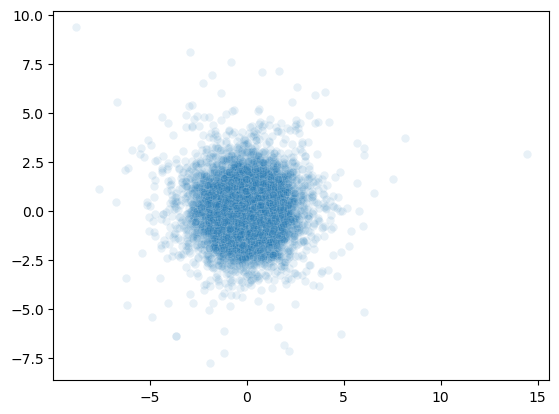

In [1287]:
sns.scatterplot(x = principle_components[:,2], y = principle_components[:,3], alpha=.1)

In [1288]:
# samples_to_pairplot = pca_df.iloc[:,:10].sample(10000)
# samples_to_pairplot["Alias"] = X.iloc[samples_to_pairplot.index].index.get_level_values("Alias").to_list()
# sns.pairplot(samples_to_pairplot, hue="Alias", palette="Paired", hue_order=["MB0" + str(i) for i in range(1,7)])

In [1289]:
# component loadings or weights (correlation coefficient between original variables and the component) 
# component loadings represents the elements of the eigenvector
# the squared loadings within the PCs always sums to 1
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i)+"{:.3f}".format(pca_out.explained_variance_ratio_[i-1]) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = X_st.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC10.018,PC20.015,PC30.014,PC40.014,PC50.013,PC60.013,PC70.013,PC80.013,PC90.013,PC100.013,...,PC780.010,PC790.010,PC800.010,PC810.010,PC820.010,PC830.010,PC840.010,PC850.010,PC860.010,PC870.000
variable,,,,,,,,,,,,,,,,,,,,,
"1bp insertion - A, 0",0.267651,0.402829,-0.058508,-0.134602,0.061204,-0.081303,-0.033603,-0.025037,0.086965,-0.098377,...,-0.108858,-0.074221,-0.063744,0.129736,-0.248131,-0.062101,0.012117,0.227326,-0.405588,0.226561
"1bp insertion - C, 0",0.105499,0.068572,0.096003,-0.121688,-0.074720,-0.130937,0.038683,0.028429,-0.037497,-0.157731,...,-0.016043,0.188173,-0.066466,-0.073818,-0.047999,0.180906,0.007503,-0.170390,0.007145,0.044632
"1bp insertion - G, 0",0.107318,0.224048,-0.049279,-0.169447,-0.059161,-0.012481,-0.163025,0.036350,-0.001150,0.052352,...,0.138804,0.033506,0.022340,-0.124971,0.042487,0.104503,-0.258799,-0.122167,-0.128116,0.083241
"1bp insertion - T, 0",0.096683,0.066732,0.033186,-0.156799,-0.192067,0.130871,0.108206,-0.056005,-0.099342,0.054346,...,0.023177,0.073643,0.043634,0.005178,0.036648,-0.042890,0.150773,0.250825,0.081586,0.058322
">1bp insertion, 0",0.149638,0.017358,0.000913,-0.080612,0.006310,-0.043237,-0.084353,0.136117,-0.135125,-0.023790,...,0.024744,0.088984,-0.004046,0.105200,-0.028265,0.065985,-0.140649,0.000117,0.004595,0.146411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Deletion with templated insertion, 0",0.048703,-0.137306,0.060535,-0.087276,-0.048167,-0.059648,-0.041005,0.035075,0.072443,0.158912,...,0.108151,-0.065704,0.022417,0.092396,-0.049376,-0.095495,0.147827,-0.155439,-0.025276,0.120544
"Homology Directed Repair, 0",-0.704738,0.283297,-0.056557,0.176910,-0.106102,0.046281,0.011604,0.010397,-0.050510,0.044436,...,0.009972,0.037153,0.040693,0.032782,-0.035881,0.038139,-0.002891,-0.029468,-0.037329,0.553272
"Large Deletion, 0",0.086462,-0.086508,-0.085068,0.078548,-0.007726,0.010984,0.148725,-0.228305,-0.124030,0.138561,...,-0.107632,-0.100708,-0.000735,-0.041183,0.021259,-0.072443,-0.022683,0.067612,0.035199,0.164472


In [1290]:
pca_scores = pca_out.transform(X_st)
pca_scores_df = pd.DataFrame(pca_scores, columns=pc_list, index=X_st.index)
pca_scores_df.head()

,PC10.018,PC20.015,PC30.014,PC40.014,PC50.013,PC60.013,PC70.013,PC80.013,PC90.013,PC100.013,...,PC780.010,PC790.010,PC800.010,PC810.010,PC820.010,PC830.010,PC840.010,PC850.010,PC860.010,PC870.000
Gene,,,,,,,,,,,,,,,,,,,,,
0610009B22Rik,-0.170763,0.421704,0.254866,-0.352667,-0.307322,0.812639,0.348012,-0.202347,-0.424871,-0.187013,...,-0.865000,0.470985,-0.138688,-0.168602,0.464478,-0.488045,0.082238,-0.228913,-0.333402,-1.682816e-16
0610010K14Rik,0.813206,-0.716049,-0.227240,0.616396,0.069369,-0.289697,0.387148,-0.415374,0.901032,0.012248,...,-0.284083,-0.073727,0.425910,0.118422,0.645003,-0.472035,-0.131648,0.280136,0.503842,9.619513e-17
0610030E20Rik,0.535889,0.708498,0.857123,-1.465401,0.310142,0.645781,-0.194520,0.005059,-0.608842,-0.157247,...,-0.386841,0.191686,0.404967,-0.625434,0.563991,0.065800,-0.807437,1.431567,1.453138,2.251702e-15
0610040J01Rik,1.677646,-2.567162,1.038076,-0.891738,-0.790013,-0.825794,0.322928,0.871353,0.034270,-1.131813,...,-0.138793,-0.034720,-0.879216,-0.395259,-0.086296,-0.803862,-0.418236,-0.204770,-1.055973,-1.438805e-15
1110004F10Rik,-1.366688,0.581731,-0.980393,0.392373,1.513001,0.972469,0.464237,1.147482,-0.296016,2.277918,...,0.432319,-1.630061,0.936216,-0.444798,-0.963843,0.209867,0.335243,0.452082,0.384729,-2.890669e-15


<AxesSubplot:ylabel='variable'>

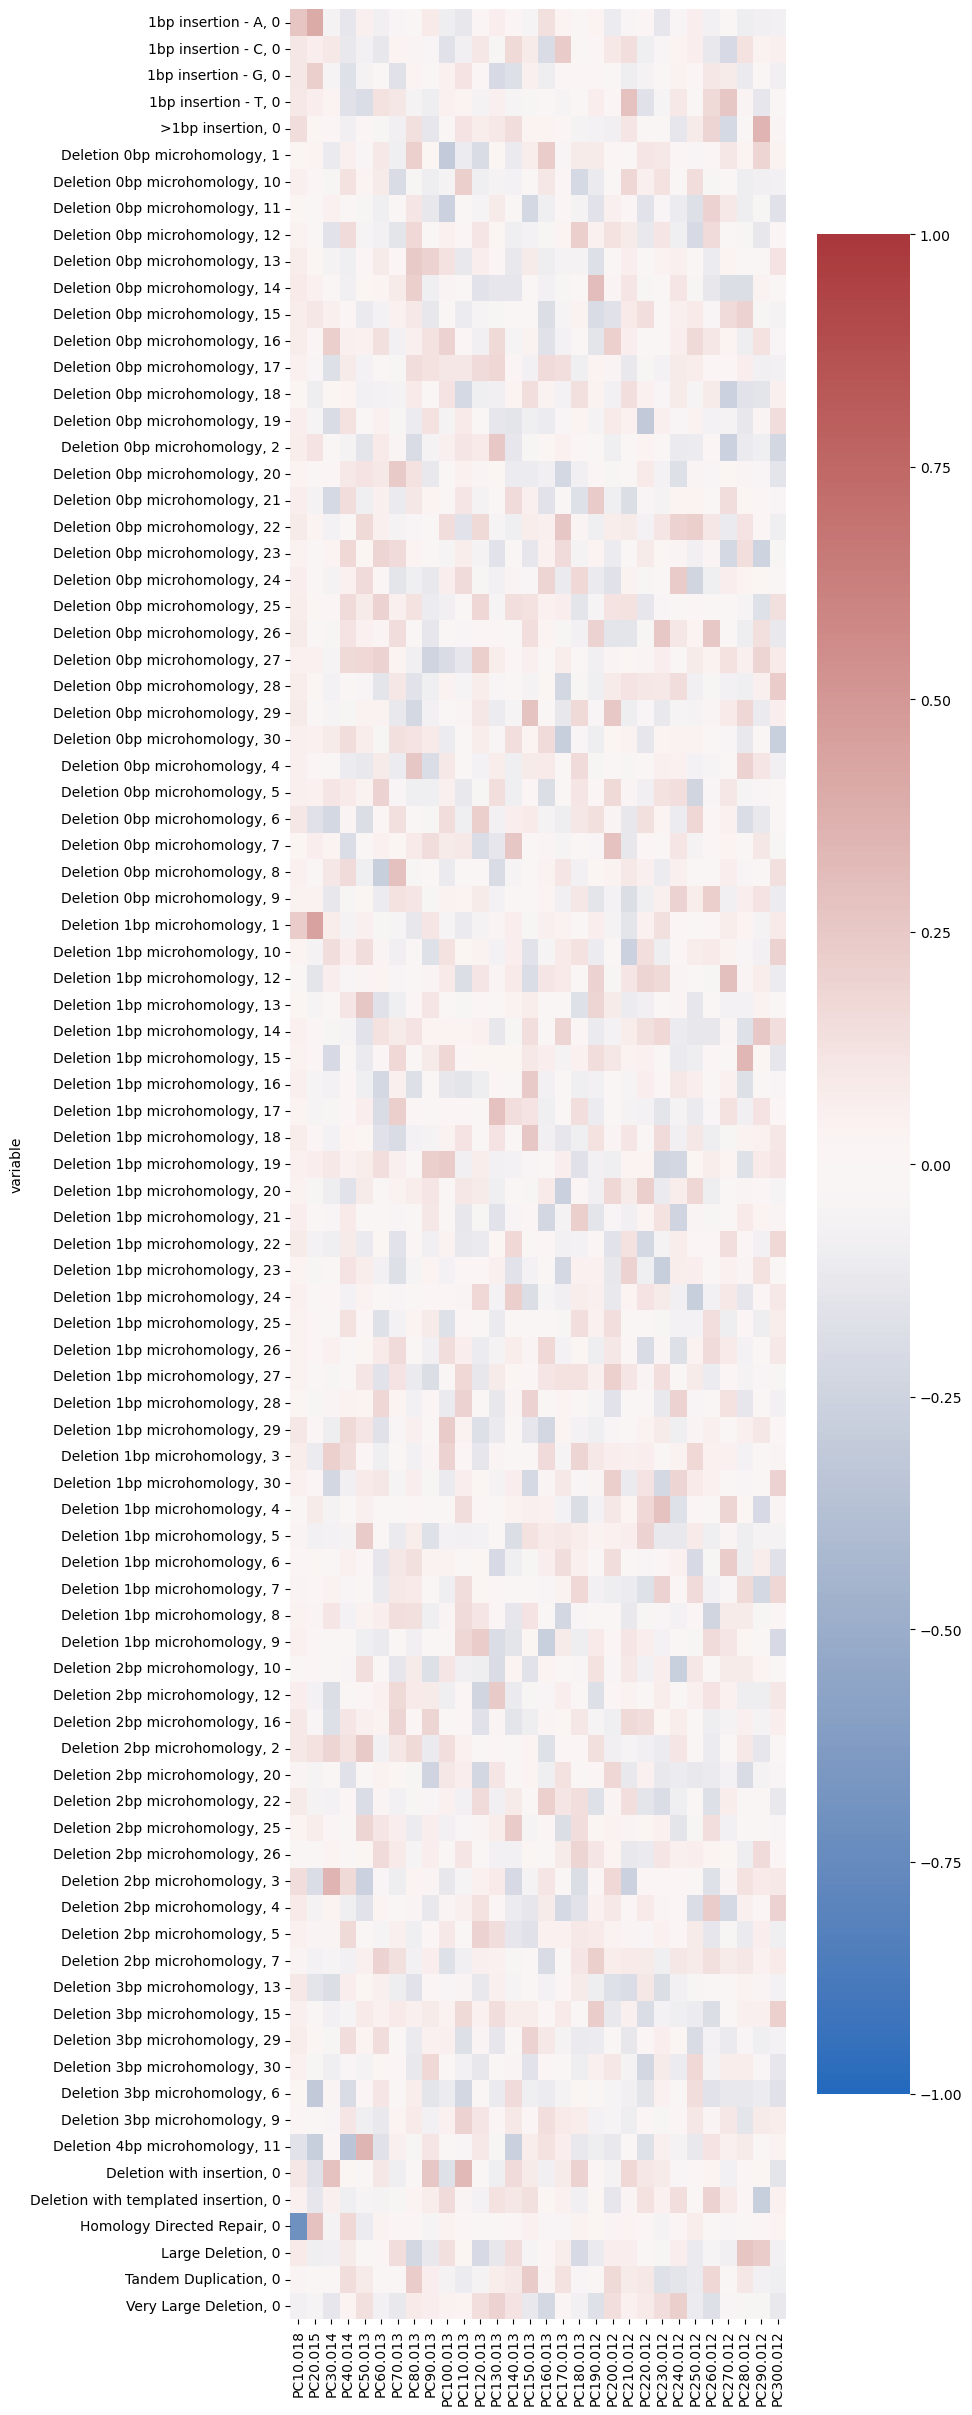

In [1291]:
plt.figure(figsize=(8, 30))
sns.heatmap(loadings_df.iloc[:,:30], center=0, vmin=-1, vmax=1, cmap="vlag")

In [1292]:
from bioinfokit.visuz import cluster

# get 2D biplot
cluster.biplot(cscore=pca_scores[np.random.choice(pca_scores.shape[0], 10000, replace=False), :], loadings=loadings, labels=X.columns.values, var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
    var2=round(pca_out.explained_variance_ratio_[1]*100, 2), show=False, dim=(20,20), figtype="pdf")


In [1293]:
# cluster.pcaplot(x=loadings[0], y=loadings[1], labels=X.columns.values, 
#     var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
#     var2=round(pca_out.explained_variance_ratio_[1]*100, 2), show=False, dim=(30,30), figtype="pdf")

In [1294]:
components_to_keep = {
    "T1": 87,
    "T2": 89,
    "T3": 87,
}
components_to_keep[target_site_to_test]
pca_df.iloc[:,:components_to_keep[target_site_to_test]].head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87
0,-0.170763,0.421704,0.254866,-0.352667,-0.307322,0.812639,0.348012,-0.202347,-0.424871,-0.187013,...,-0.865000,0.470985,-0.138688,-0.168602,0.464478,-0.488045,0.082238,-0.228913,-0.333402,-1.682816e-16
1,0.813206,-0.716049,-0.227240,0.616396,0.069369,-0.289697,0.387148,-0.415374,0.901032,0.012248,...,-0.284083,-0.073727,0.425910,0.118422,0.645003,-0.472035,-0.131648,0.280136,0.503842,9.619513e-17
2,0.535889,0.708498,0.857123,-1.465401,0.310142,0.645781,-0.194520,0.005059,-0.608842,-0.157247,...,-0.386841,0.191686,0.404967,-0.625434,0.563991,0.065800,-0.807437,1.431567,1.453138,2.251702e-15
3,1.677646,-2.567162,1.038076,-0.891738,-0.790013,-0.825794,0.322928,0.871353,0.034270,-1.131813,...,-0.138793,-0.034720,-0.879216,-0.395259,-0.086296,-0.803862,-0.418236,-0.204770,-1.055973,-1.438805e-15
4,-1.366688,0.581731,-0.980393,0.392373,1.513001,0.972469,0.464237,1.147482,-0.296016,2.277918,...,0.432319,-1.630061,0.936216,-0.444798,-0.963843,0.209867,0.335243,0.452082,0.384729,-2.890669e-15


In [1295]:
# calculate mahalanobis distance chapter 3.3.1 of outlier analysis second version
from scipy.stats import chi2

mahal_df = pd.DataFrame({"mahal_dist": np.sum(np.square(pca_df.iloc[:,:components_to_keep[target_site_to_test]]).values, axis=1)}, index=X.index)  
mahal_df['p'] = 1 - chi2.cdf(mahal_df['mahal_dist'], components_to_keep[target_site_to_test] - 1)

In [1296]:
# need to do FDR correction with multiple hypothesis testing

from statsmodels.stats.multitest import fdrcorrection
fdr_results = fdrcorrection(mahal_df['p'], alpha=0.05)
mahal_df["rejected"] = fdr_results[0]
mahal_df["p_corrected"] = fdr_results[1]


In [1297]:
mahal_df.loc["Polm"]

mahal_dist     74.450285
p               0.808406
rejected           False
p_corrected          1.0
Name: Polm, dtype: object

In [1298]:
mahal_df["mahal_dist"]

Gene
0610009B22Rik    34.146439
0610010K14Rik    24.831875
0610030E20Rik    81.347058
0610040J01Rik    78.470581
1110004F10Rik    74.192842
                   ...    
Zzef1            37.854346
Zzz3             51.755032
a                59.973293
ccdc198          62.457694
mei-04           79.167949
Name: mahal_dist, Length: 17547, dtype: float64

In [1299]:
from pyod.models.mcd import MCD

mcd_output = MCD(random_state=0).fit(X)

In [1300]:
pvalues = 1 - chi2.cdf(mcd_output.decision_scores_, X.shape[1] - 1)
rejected, corrected_pvalues = fdrcorrection(pvalues, alpha=0.05)
mcd_df = pd.DataFrame({
    "mcd_mahal": pvalues,
    "mcd_rejected": rejected,
    "mcd_p_corrected": corrected_pvalues,
    }, index=X.index) 
mcd_df["mcd_rejected"].sum()

7244

In [1301]:
mcd_df.loc["Polm"]

mcd_mahal          0.025344
mcd_rejected          False
mcd_p_corrected    0.060177
Name: Polm, dtype: object

In [1302]:
from pyod.models.ecod import ECOD

ecod_output = ECOD(contamination=.3).fit(X)
ecod_output.decision_scores_

array([109.49577787, 105.80157073, 135.80675855, ..., 131.15646111,
       122.88251492, 135.19339373])

In [1303]:
a = pd.Series(ecod_output.decision_scores_, index=X.index)

In [1304]:
a.sort_values(ascending=False).loc["Polm"]

135.35144342995923

In [1305]:
df[(df["lumc_category"] == "Deletion 0bp microhomology") & (df["del_len"] == 9)].groupby(["Target", "Gene"]).size().max()

30

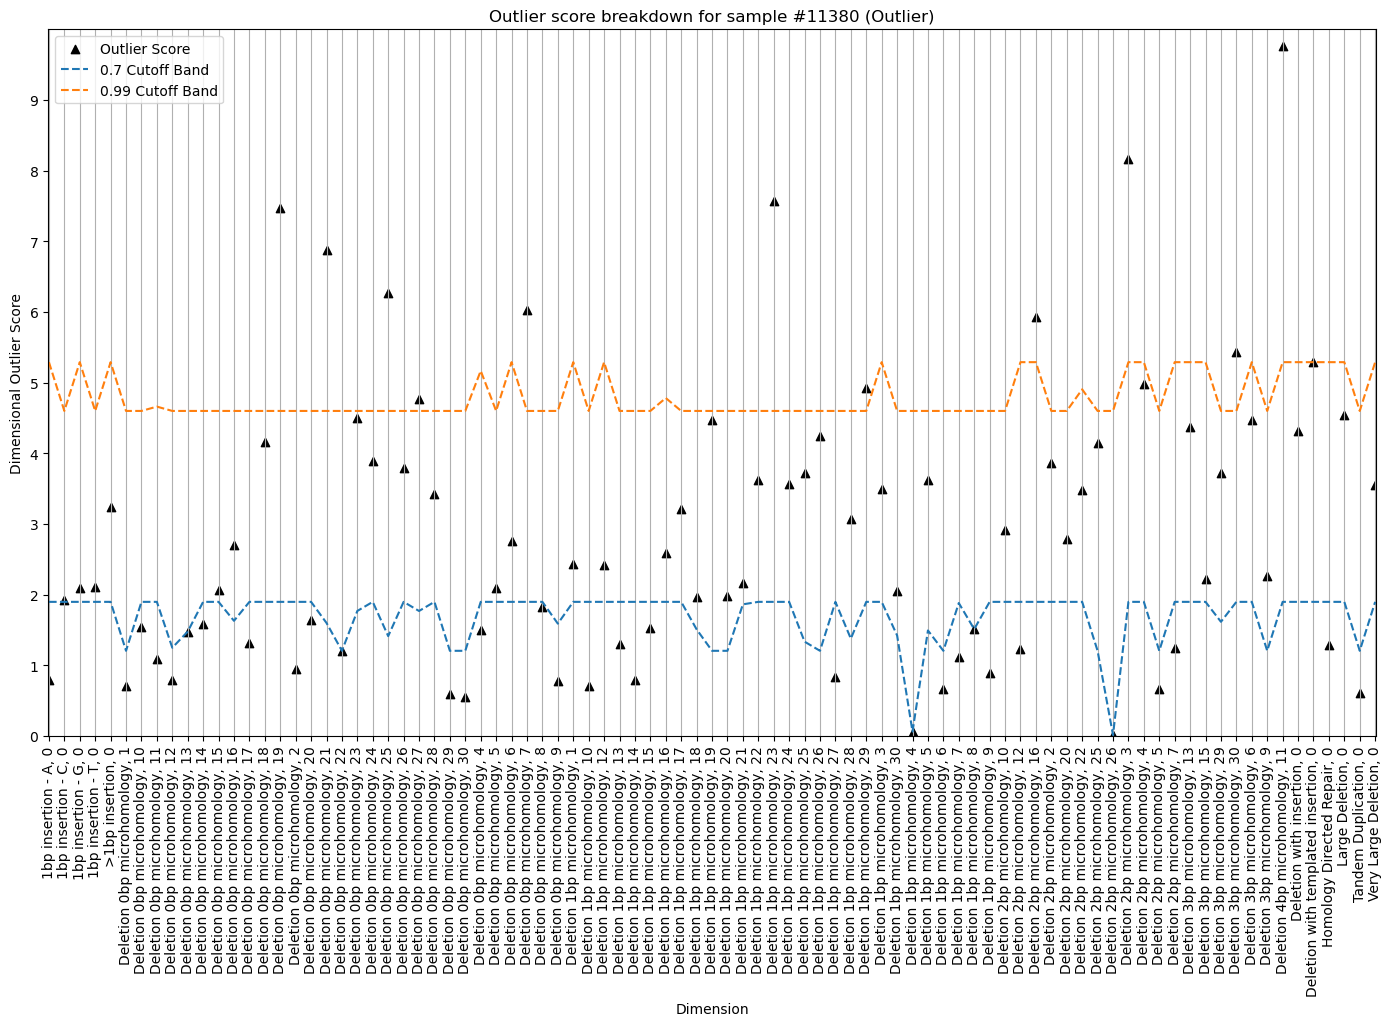

In [1306]:
from src.visualization.ecod import explain_outlier

plt.figure(figsize=(15, 8))
explain_outlier(ecod_output, X.index.get_loc("Polq"), feature_names=X.columns.to_list())

In [1307]:
from pyod.models.iforest import IForest

iforest_output = IForest(contamination=.3).fit(X)
iforest_output.decision_scores_

array([-0.04139341, -0.05401465, -0.01712628, ...,  0.00072128,
       -0.01049352, -0.00082396])

In [1308]:
a = pd.Series(iforest_output.decision_scores_, index=X.index).sort_values(ascending=False)
a

Gene
Atp6v1b2    0.171901
Ints9       0.169206
Vmn1r53     0.168494
Ppp2r3c     0.164257
Krtap4-2    0.163609
              ...   
Akain1     -0.063574
Ccser2     -0.063706
Trappc14   -0.063898
Szt2       -0.065245
Tsc2       -0.067616
Length: 17547, dtype: float64

In [1309]:
fi = pd.Series(iforest_output.feature_importances_, index=X.columns.to_list())
fi.sort_values(ascending=False).head(20)

Deletion 1bp microhomology, 22    0.017718
1bp insertion - T, 0              0.016966
>1bp insertion, 0                 0.016900
Deletion 1bp microhomology, 28    0.015992
Deletion 0bp microhomology, 1     0.015334
Deletion 3bp microhomology, 15    0.014981
Deletion 1bp microhomology, 19    0.014736
Deletion 3bp microhomology, 13    0.014702
Deletion 1bp microhomology, 17    0.014641
Deletion 1bp microhomology, 5     0.014569
Homology Directed Repair, 0       0.014190
Deletion 2bp microhomology, 10    0.014181
Very Large Deletion, 0            0.013970
Deletion 1bp microhomology, 12    0.013766
Deletion 0bp microhomology, 13    0.013707
Deletion 0bp microhomology, 30    0.013590
Deletion 3bp microhomology, 6     0.013471
Deletion 0bp microhomology, 11    0.013348
Tandem Duplication, 0             0.013309
Deletion 0bp microhomology, 24    0.013076
dtype: float64

In [1310]:
import pickle
from src.config import get_interim_dir

# need to add code to save 
# profile matrix
# pca object
# outlier analysis
# for each target site for further analysis

pca_analysis = {
    "X": X,
    "scaler": scaler,
    "pca_out": pca_out,
    "ecod_out": ecod_output,
    "iforest_out": iforest_output,
    "mcd_out": mcd_output,
    "mahal_out": mahal_df
    
}

pickle.dump(pca_analysis, open(get_interim_dir() + "agg_pca_analysis_{}.pkl".format(target_site_to_test), 'wb'))